# 多体系量子力学（2022年春 Lab3）

```{note}
このNotebookはQiskit v0.44の仕様に合わせてコードを改変しています。
```

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.visualization import *

from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi

# from qc_grader.challenges.spring_2022.helpers import generate_disordered_tb_instruction

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [50]:
# https://github.com/qiskit-community/Quantum-Challenge-Grader/blob/main/qc_grader/challenges/spring_2022/helpers/__init__.py
from typing import List
from qiskit.circuit import Instruction

def generate_ZZ(t: Parameter) -> Instruction:
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')
    ZZ_qc.cnot(0, 1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0, 1)
    ZZ = ZZ_qc.to_instruction()
    return ZZ


def generate_XX(t: Parameter) -> Instruction:
    ZZ = generate_ZZ(t)
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr, name='XX')
    XX_qc.h([0, 1])
    XX_qc.append(ZZ, [0, 1])
    XX_qc.h([0, 1])
    XX = XX_qc.to_instruction()
    return XX


def generate_YY(t: Parameter) -> Instruction:
    ZZ = generate_ZZ(t)
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr, name='YY')
    YY_qc.sdg([0, 1])
    YY_qc.h([0, 1])
    YY_qc.append(ZZ, [0, 1])
    YY_qc.h([0, 1])
    YY_qc.s([0, 1])
    YY = YY_qc.to_instruction()
    return YY
    
def generate_tb_trotter_instruction(
    t: Parameter,
    num_qubits: int
) -> Instruction:
    XX = generate_XX(t)
    YY = generate_YY(t)

    Trot_qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')
    for i in np.arange(0, num_qubits - 1, 2):
        Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
        Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

    for i in np.arange(1, num_qubits - 1, 2):
        Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
        Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])
    Trot_gate = Trot_qc.to_instruction()

    return Trot_gate

def generate_disordered_tb_instruction(
    t: Parameter,
    deltas: List[int],
    num_qubits: int
) -> Instruction:
    Trot_qr_disorder = QuantumRegister(num_qubits)
    Trot_qc_disorder = QuantumCircuit(Trot_qr_disorder, name='Trot disorder')

    tb_trotter_instruction = generate_tb_trotter_instruction(t, num_qubits)
    Trot_qc_disorder.append(tb_trotter_instruction, [i for i in range(num_qubits)])

    for idx in range(num_qubits):
        Trot_qc_disorder.rz(2 * t * deltas[idx], idx)

    # Convert custom quantum circuit into a gate
    Trot_disorder_gate = Trot_qc_disorder.to_instruction()

    return Trot_disorder_gate

## はじめに
このExerciseでは、格子の無秩序性（乱れ）と格子間の相互作用を調べていきます。
非平衡に初期化された閉じた量子多体系では、それ自身のダイナミクスの下で熱化と呼ばれる平衡状態に到達します。この振る舞いは、統計力学の法則による結果として、ホットコーヒーを置きっぱなしにしたとき、冷めていって周囲の温度に到達するのと同じです。

しかし、格子の乱れの存在により、系がエルゴード熱平衡状態へ変化するのが妨げられます。
これによって、乱れと粒子の相互作用との間での相互作用の結果、多体局在( many-body localization, MBL)となり、つまり、系が常に初期状態を記憶しておくことになります。MBLについてのより詳細な情報は[1]を参照ください。

任意の格子エネルギーにおける強結合ハミルトニアンを再び考えます：

$$H_{\rm tb}/\hbar = \sum^{3}_{i=0} (X_i X_{i+1} + Y_i Y_{i+1}) + \sum_i \epsilon_i Z_i $$

Exercise 2で学んだように、この系における無秩序性を$\epsilon_i=W \rm{cos}(2\pi\beta i)$とおくことで模倣することができます。ここで、$W$は無秩序性の強さ、$\beta$は準結晶の周期性を決定します。
系に複数の粒子を追加するには、ユニタリー時間発展の前に粒子を$|1\rangle$状態に初期化します。
$H_{\rm tb}$の下では、各格子点は、それぞれ一つの格子で占有され、その結果、粒子の反発相互作用が生じます。

[1] https://arxiv.org/abs/1804.11065

熱平衡化の破れの兆候の一つは、 **不均衡** が生じることです。
熱平衡システムにおいては、平衡状態に到達すると、各格子点は等しい平均粒子数によって占有されることが期待されますが、相互作用のある系に乱れを加えると、各格子点で観測された熱の値から偏差が発生します。この系の不均衡は、以下の式によって定量化できます。

$$\mathcal{I}= \langle (N_e-N_o)/(N_e+N_o) \rangle$$

ここで、$N_e$ と $N_o$は、系の偶数の格子と奇数の格子の占有数です。熱平衡システムでは、$\mathcal{I}=0$となり、系の乱れがこの値からの偏差を生じます。

いくつかの例を考えてみましょう：

1. $ |\psi\rangle = |0111\rangle $:
 
   \begin{align*}
   \langle \psi | N_e | \psi \rangle &= 1 \\
   \langle \psi | N_o | \psi \rangle &= 2 \\
   \mathcal{I} = \langle \psi |  (N_e-N_o)/(N_e+N_o) | \psi \rangle &= -1/3
   \end{align*}

2. $ |\psi\rangle = \sqrt{2/3} |0111\rangle + \sqrt{1/3} |1011\rangle $: 
$$ \langle \psi |  \mathcal{I} | \psi \rangle = 2/3 * \langle 0111 |  \mathcal{I} |0111\rangle + 1/3 * \langle 1011 |  \mathcal{I} |1011\rangle $$

   \begin{align*}
   \langle 0111 |  \mathcal{I} |0111\rangle &= -1/3 \\
   \langle 1011 |  \mathcal{I} |1011\rangle &= 1/3 \\
    \langle \psi |  \mathcal{I} | \psi \rangle &= -1/9
   \end{align*}

### Challenge question 3a
    
````{admonition} 量子状態の不均衡
量子状態の不均衡を出力する関数を書いてください。

```python
def get_imbalance(state):
    ###EDIT CODE BELOW
    ### HINT: MAKE SURE TO SKIP CALCULATING IMBALANCE OF THE |00...0> STATE
    imbalance_val=0
    
    
    ###DO NOT EDIT BELOW
    
    return imbalance_val
```
````

In [ ]:
def get_imbalance(state):
    ### HINT: MAKE SURE TO SKIP CALCULATING IMBALANCE OF THE |00...0> STATE
    imbalance_val=0

    props = state.probabilities_dict()
    for _state, probability in props.items():
        ne = 0
        no = 0
        for i in range(state.num_qubits):
            if (_state[i] == '1'):
                if (i % 2 == 0):
                    ne += 1
                else:
                    no += 1
        
        if (ne + no == 0):
            continue

        imbalance_val += probability * (ne - no) / (ne + no)
    
    ###DO NOT EDIT BELOW
    
    return imbalance_val

```{admonition} 解説
:class: tip
状態に対して0量子ビット目から1かどうかを確認して$N_e$、$N_o$をカウントしていき不均衡の式にしたがって計算することで答えが得られる。ただし、Qiskitでは後ろから第0量子ビット、第1量子ビットと数えていくため、先頭を第0量子ビットとする場合には、量子ビットの個数が偶数の時不均衡の符号が反転する。Quantum Challengeが開催された際には後者でgraderが通ったため、そちらを採用した。
```

次に、量子情報とエンタングルメント・エントロピーが系においてどのように成長するかを考えます。
エンタングルした系では、系がそのままでいるための情報を無視することで部分系を異なる数の状態の混合状態になります。 部分系$A$と残りの系の間のエンタングルメントの度合いに洞察を得ることで**フォン・ノイマン・エントロピー** を調べられます：

$$\mathcal{S}_{\rm vn}(\rho_A)= -\rm{tr}(\rho_A \rm{ln} \rho_A)$$
 
ここで、$\rho_A= \rm{tr}_{\bar{A}} \rho$は、系の残りをトレースアウトしたときの部分系$A$を記述する縮約密度行列です。部分系$A$が、系の残りと完全にエンタングルしているとき、$\mathcal{S}_{\rm vn}(\rho_A) = \rm{ln}2$となり、またその環境において（積状態において）完全に分解できるとき$\mathcal{S}_{\rm vn}(\rho_A)=0$です。以下の例を考えてみてください：

In [64]:
bell_state = qi.Statevector(np.array([0,1,1,0])/np.sqrt(2))

rho_0 = qi.partial_trace(bell_state,[1]) # We trance out qubit 1
rho_1 = qi.partial_trace(bell_state,[0]) # We trace out qubit 0

print('QB0 vn entropy: ', qi.entropy(rho_0, base=np.exp(1)))
print('QB1 vn entropy: ', qi.entropy(rho_1, base=np.exp(1)))

QB0 vn entropy:  0.6931471805599454
QB1 vn entropy:  0.6931471805599454


## 12量子ビット鎖において多体量子力学を調べる

Exerciseのこのパートでは、Exercise 2で調べた格子の乱れのパターンと同じものを使います。

In [65]:
t = Parameter('t')

In [66]:
num_qubits=12
deltas=[Parameter('delta_{:d}'.format(idx)) for idx in range(num_qubits)]
disorder_trot_step=generate_disordered_tb_instruction(t, deltas, num_qubits)

In [67]:
# Here we define the disorder pattern

beta=(np.sqrt(5)-1)/2 # DO NOT EDIT
AA_pattern=np.cos(2*np.pi*beta*np.arange(num_qubits)) # DO NOT EDIT

### Challenge question 3b
    
````{admonition} 系の初期化
qubits 0, 4, 8 を$|1\rangle$に設定することで系を初期化してください。

```python
delta_t=0.1
time_steps=np.arange(0,21,2)

circuits={}
Ws=[1,4,10]

for W in Ws:
    disorders=W*AA_pattern
    
    circuits[W]=[]

    for n_steps in time_steps:

        qr = QuantumRegister(num_qubits)
        qc = QuantumCircuit(qr)

        ###EDIT CODE BELOW
        
        
        ###DO NOT EDIT BELOW     

        for _ in range(n_steps):
            qc.append(disorder_trot_step, [i for i in range(num_qubits)])
        
        if n_steps!=0:
            qc = qc.bind_parameters({t: delta_t})
            qc = qc.bind_parameters({deltas[idx]: disorders[idx] for idx in range(num_qubits)})

        circuits[W].append(qc)
```
````

In [ ]:
delta_t=0.1
time_steps=np.arange(0,21,2)

circuits={}
Ws=[1,4,10]

for W in Ws:
    disorders=W*AA_pattern
    
    circuits[W]=[]

    for n_steps in time_steps:

        qr = QuantumRegister(num_qubits)
        qc = QuantumCircuit(qr)

        ###EDIT CODE BELOW
        qc.x([0, 4, 8])
        
        
        ###DO NOT EDIT BELOW     

        for _ in range(n_steps):
            qc.append(disorder_trot_step, [i for i in range(num_qubits)])
        
        if n_steps!=0:
            qc = qc.bind_parameters({t: delta_t})
            qc = qc.bind_parameters({deltas[idx]: disorders[idx] for idx in range(num_qubits)})

        circuits[W].append(qc)

```{admonition} 解説
:class: tip
指示通りに$X$ゲートをかけて0,4,8番目の量子ビットを1にすればよい。
```

### Challenge question 3c,3d
    
````{admonition} フォン・ノイマン・エントロピー
乱れの強さを変化させ、それぞれの時間発展のステップにおいて、qubit 0 のフォン・ノイマン・エントロピーを取り出してください。  
また、乱れの強さを変化させ、それぞれの時間発展のステップにおいて、格子の不平衡を取り出してください。

```python
from qiskit import transpile

# Use Aer's statevector simulator
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend_sim = Aer.get_backend('statevector_simulator')

probability_densities={}
state_vector_imbalances={}
vn_entropies={}

for W in tqdm(Ws):
    probability_densities[W]=[]
    state_vector_imbalances[W]=[]
    vn_entropies[W]=[]
    
    for circ in circuits[W]:

        transpiled_circ=transpile(circ, backend_sim, optimization_level=3)

        job_sim = backend_sim.run(transpiled_circ)

        # Grab the results from the job.
        result_sim = job_sim.result()
        outputstate = result_sim.get_statevector(transpiled_circ, decimals=6)
        ps=[]
        for idx in range(num_qubits):
            ps.append(np.abs(qi.partial_trace(outputstate,[i for i in range(num_qubits) if i!=idx]))[1,1]**2)
        
        entropy=0
        ### EDIT CODE BELOW (extract the density matrix of qubit 0 by tracing out all other qubits)
        
        
        ###DO NOT EDIT BELOW 
        
        imbalance=0
        ### EDIT CODE BELOW 
        
        
        ###DO NOT EDIT BELOW
        
        
        vn_entropies[W].append(entropy)
        probability_densities[W].append(ps)
        state_vector_imbalances[W].append(imbalance)
```
````

In [ ]:
from qiskit import transpile

# Use Aer's statevector simulator
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend_sim = Aer.get_backend('statevector_simulator')

probability_densities={}
state_vector_imbalances={}
vn_entropies={}

for W in Ws:
    probability_densities[W]=[]
    state_vector_imbalances[W]=[]
    vn_entropies[W]=[]
    
    for circ in circuits[W]:

        transpiled_circ=transpile(circ, backend_sim, optimization_level=3)

        job_sim = backend_sim.run(transpiled_circ)

        # Grab the results from the job.
        result_sim = job_sim.result()
        outputstate = result_sim.get_statevector(transpiled_circ, decimals=6)
        ps=[]
        for idx in range(num_qubits):
            ps.append(np.abs(qi.partial_trace(outputstate,[i for i in range(num_qubits) if i!=idx]))[1,1]**2)
        
        entropy=0

        extract_qubit_list = [i for i in range(1, outputstate.num_qubits)]
        rho = qi.partial_trace(outputstate, extract_qubit_list)
        entropy = qi.entropy(rho, base=np.exp(1))
        
        imbalance=0
        imbalance += get_imbalance(outputstate)
        
        vn_entropies[W].append(entropy)
        probability_densities[W].append(ps)
        state_vector_imbalances[W].append(imbalance)

```{admonition} 解説
:class: tip
0量子ビットのフォン・ノイマン・エントロピーを取り出すので、0量子ビット以外、つまり1量子ビット目以降の量子ビットをトレースアウトして縮約密度行列を求める。その状態に対してqi.entropy()でエントロピーを計算することでentropy変数が求まる。不均衡についてはChallenge 3aで定義したget_imbalance関数を用いることで計算することができる。
```

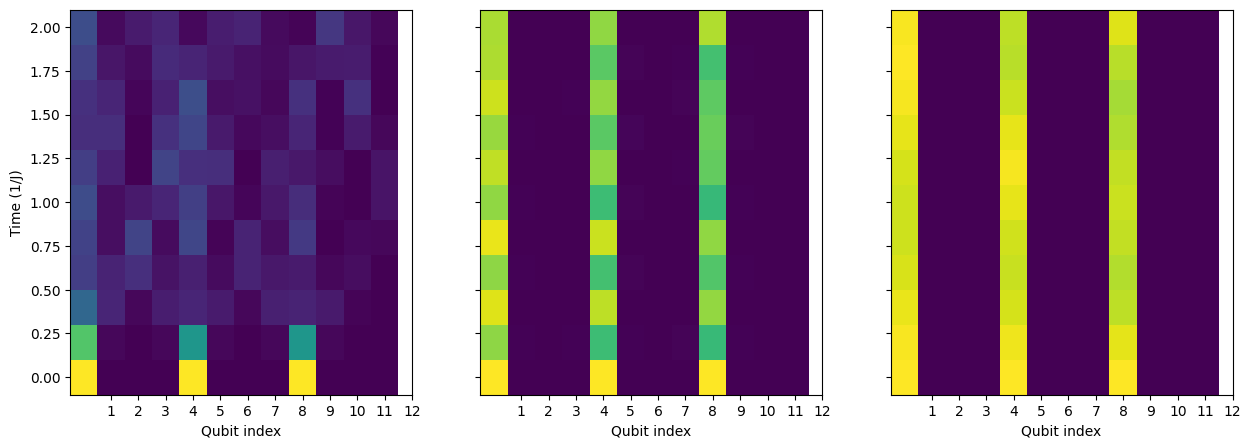

In [70]:
fig, axs = plt.subplots(1,3,figsize=(15,5), facecolor='white', sharey=True)

for i,W in enumerate(Ws):
    ax=axs[i]
    ax.pcolormesh(np.arange(0,num_qubits,1), time_steps*delta_t ,probability_densities[W])
    ax.set_xlabel('Qubit index')
    ax.set_xticks(np.arange(1,num_qubits+1,1))

axs[0].set_ylabel('Time (1/J)')

plt.show()

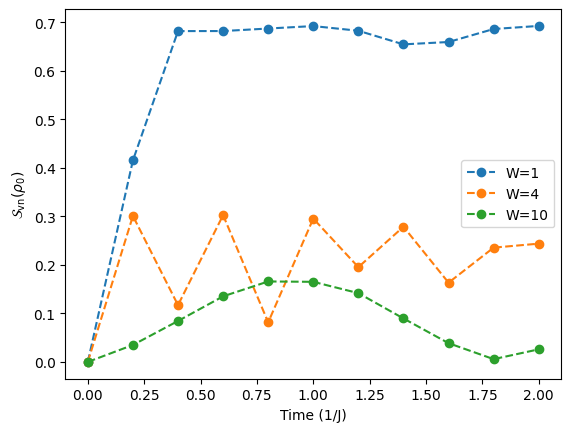

In [73]:
for W in Ws:
    plt.plot(time_steps*delta_t,vn_entropies[W], '--o', label='W={:d}'.format(W))

plt.xlabel(r'Time (1/J)')
plt.ylabel(r'$\mathcal{S}_{\rm vn}(\rho_0)$')
plt.legend()
plt.show()

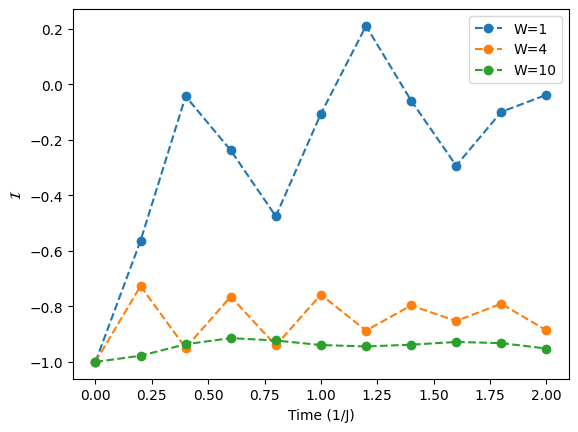

In [74]:
for W in Ws:
    plt.plot(time_steps*delta_t,state_vector_imbalances[W], '--o', label='W={:d}'.format(W))

plt.xlabel(r'Time (1/J)')
plt.ylabel(r'$\mathcal{I}$')
plt.legend()
plt.show()